In [1]:
%load_ext autoreload
%autoreload 2

In [346]:
import pandas as pd
from import_data_example import get_demand, get_gen, get_mcp, get_vre
from environment_kim import market_env
from actor_critic import ActorCriticAgent
import numpy as np
import torch

In [287]:
start = pd.Timestamp(year=2020, month=1, day=1, tz="europe/brussels")
end = pd.Timestamp.now(tz="europe/brussels").floor('D') + pd.Timedelta(days=1)

In [347]:
df_demand, df_demand_scaled = get_demand(start, end)
df_vre, df_vre_scaled = get_vre(start, end)
df_gen, df_gen_scaled = get_gen(start, end)
df_mcp = get_mcp(start, end)

KeyboardInterrupt: 

In [359]:
# Example usage
env = market_env(demand=df_demand_scaled, re = df_vre_scaled, prices = df_mcp, eps_length=24, capacity=200, mc=30)

# Assuming you have a gym environment called 'env'
input_size = env.observation_space.shape[0]
n_actions = env.action_space.n
n_games = 500

agent = ActorCriticAgent(input_size, n_actions)

filename = 'power_plant.png'

figure_file = 'plots/' + filename

best_score = env.reward_range[0]
score_history = []
load_checkpoint = False

/Users/louis.skowronek/miniforge3/envs/bda_env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [360]:
reward_history = []

if load_checkpoint:
    agent.load_models()

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0

    while not done:

        action = agent.choose_action(observation)

        observation_next, reward, done, _ = env.step(action)
        score += reward
        if not load_checkpoint:
            agent.update(observation, reward, observation_next, done)
        observation = observation_next

    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        if not load_checkpoint:
            agent.save_models()
    break
    print('episode ', i, 'score %.1f' % score, 'avg_score %.1f' % avg_score)

... saving models ...


In [351]:
env.results_ep.describe()

,reward,market price,bid price,bid volume
count,9888.000000,9888.000000,9888.000000,9888.0
mean,18630.931634,120.544743,29.973301,200.0
std,24619.951554,125.299354,0.902720,0.0
min,0.000000,-69.000000,0.000000,200.0
25%,1419.500000,37.097500,30.000000,200.0
50%,8739.000000,73.695000,30.000000,200.0
75%,26825.000000,164.125000,30.000000,200.0
max,164000.000000,850.000000,48.000000,200.0


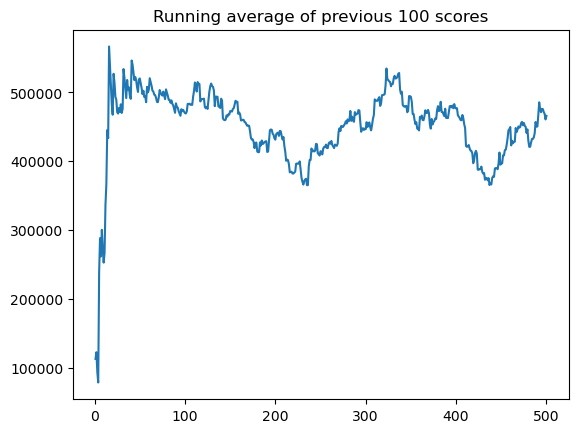

In [352]:
x = [i + 1 for i in range(len(score_history))]
plot_learning_curve(x, score_history)

In [361]:
state =  env.observe_state(df_demand_scaled.index[0])

In [362]:
state = torch.from_numpy(state).float()

In [364]:
_, probs = agent.model(state)
probs

tensor([0.0322, 0.1445, 0.0211, 0.0063, 0.0296, 0.0101, 0.2335, 0.3868, 0.1328,
        0.0033], grad_fn=<SoftmaxBackward0>)

In [357]:
action

array(5)

In [210]:
state = torch.from_numpy(state).float()
_, probs = self.model(state)
action_dist = torch.distributions.Categorical(probs=probs)
action = action_dist.sample()
self.action = action

24.0

In [171]:
state = torch.from_numpy(state).float()
_ , probs = agent.model(state)
action_dist = torch.distributions.Categorical(probs=probs)
action = action_dist.sample()



In [172]:
agent.model(state)

(tensor([-47.7459], grad_fn=<AddBackward0>),
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], grad_fn=<SoftmaxBackward0>))

array([5.0473e+04, 0.0000e+00, 4.8300e+03, 1.7593e+04, 3.0000e+01])

In [227]:
state = torch.from_numpy(env.observation).float()
_, probs = agent.model(state)

In [243]:
agent = ActorCriticAgent(input_size, n_actions)

In [249]:
_, probs = agent.model(state)

In [245]:
import torch.nn.functional as F

In [252]:
probs

tensor([-5186.8765,  1750.0256, -1454.3394,  3379.9880,   773.9310, -1769.9963,
          177.4805, -1122.4966,  -568.8074,  3021.6191],
       grad_fn=<AddBackward0>)

In [258]:
F.softmax(probs, dim=-1)

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], grad_fn=<SoftmaxBackward0>)

In [180]:
observation = env.observe_state(env.date)

# get bid from action
bid_volume = env.capacity

# the bid price is relative to the marginal costs
bid_price = action / 10 * 2 * env.mc

profit, da_price = env.market_clearing(bid_price, bid_volume, env.date)

# scale the reward
reward = (profit / env.reward_scaling)

In [187]:
profi

array([11184.])

In [190]:
env.prices.loc[env.date]

85.92